# Fine-Tuning with Semantic Segmentation

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install torchinfo
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-lqssy3j5
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-lqssy3j5
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e7cbea0bbd546167b9d1757b2cfeca3fbe26a33e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 17.3 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.2-py

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torchinfo
import segmentation_models_pytorch as smp
from transformers import get_linear_schedule_with_warmup

In [3]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


In [4]:
!nvidia-smi

Sun Apr  2 13:54:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# prepare data
!unzip '/content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/img.npy.zip'
!unzip '/content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/label.npy.zip'
!unzip '/content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/size.npy.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/img.npy.zip
  inflating: img.npy                 
Archive:  /content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/label.npy.zip
  inflating: label.npy               
Archive:  /content/drive/MyDrive/Colab Notebooks/ADL Group Project/preprocessed data/size.npy.zip
  inflating: size.npy                


In [9]:
test_img = np.load('img.npy')
print(test_img.shape)

test_label = np.load('label.npy')
print(test_label.shape)

test_size = np.load('size.npy')
print(test_size.shape)

(7390, 256, 256, 3)
(7390, 256, 256)
(7390, 2)


In [10]:
test_label[test_label==1] = 0
test_label[test_label==2] = 1
test_label[test_label==3] = 2

np.unique(test_label)

array([0, 1, 2], dtype=uint8)

[256 170]


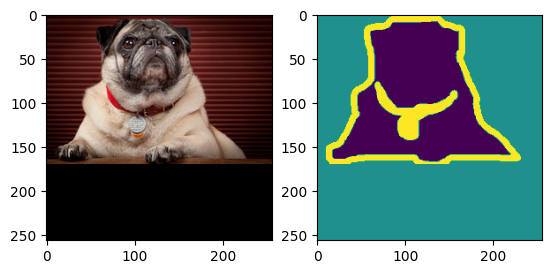

In [11]:
_, ax = plt.subplots(nrows = 1,ncols = 2)
ax[0].imshow(test_img[1])
ax[1].imshow(test_label[1])
print(test_size[0])

## Generate Padding Masks

In [12]:
test_mask = np.zeros_like(test_img[:,:,:,0])
for i in range(len(test_img)):
  test_mask[i,0:test_size[i,0],0:test_size[i,1]] = 1

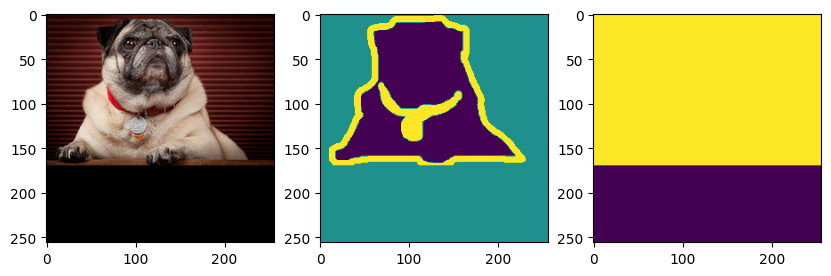

In [13]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
ax[0].imshow(test_img[1])
ax[1].imshow(test_label[1].astype(int))
ax[2].imshow(test_mask[1]*255.)

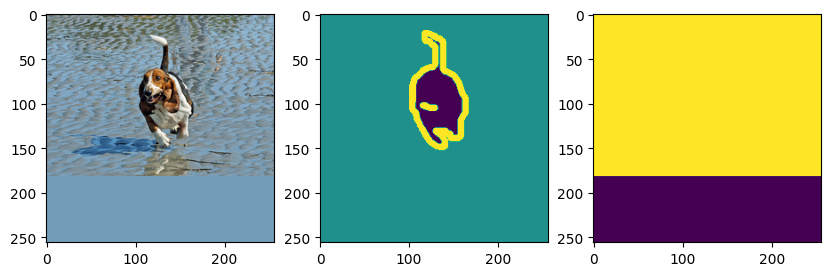

In [14]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,6))
ax[0].imshow(test_img[13])
ax[1].imshow(test_label[13].astype(int))
ax[2].imshow(test_mask[13]*255.)

## Dataset

In [15]:
class Finetune_set(Dataset):
  
  def __init__(self, img, label, mask):
    super().__init__()
    self.img = torch.Tensor(img).float().permute((0,3,1,2))/255.
    self.label = torch.Tensor(label).float() 
    self.mask = torch.Tensor(mask).float()

  def __len__(self):
    return len(self.img)

  def __getitem__(self,idx):
    return self.img[idx], self.label[idx], self.mask[idx]

In [16]:
np.random.seed(42)

ids = list(range(test_img.shape[0]))
np.random.shuffle(ids)

# 40% labelled data, 60% unlabelled data
labelled_ids = ids[:int(0.4*test_img.shape[0])]
unlabelled_ids = ids[int(0.4*test_img.shape[0]):]

# 80% training, 5% validation, 15% test
train_ids = labelled_ids[:int(0.8*len(labelled_ids))]
valid_ids = labelled_ids[int(0.8*len(labelled_ids)):int(0.85*len(labelled_ids))]
test_ids = labelled_ids[int(0.85*len(labelled_ids)):]

# validation and test sets stay the same
valid_set = Finetune_set(test_img[valid_ids], test_label[valid_ids], test_mask[valid_ids])
test_set = Finetune_set(test_img[test_ids], test_label[test_ids], test_mask[test_ids])
print(len(valid_set), len(test_set))

# training set for baseline and semi-supervised
base_train_set = Finetune_set(test_img[train_ids], test_label[train_ids], test_mask[train_ids])
print(len(base_train_set))

# training set for upper bound
upper_train_set = Finetune_set(test_img[train_ids+unlabelled_ids], test_label[train_ids+unlabelled_ids], test_mask[train_ids+unlabelled_ids])
print(len(upper_train_set))

148 444
2364
6798


In [43]:
batch_size = 64

# validation and test sets stay the same
valid_loader = DataLoader(valid_set, shuffle=False, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, num_workers=2)

# need to choice which trainset to use
train_loader = DataLoader(base_train_set, shuffle=True, batch_size=batch_size, num_workers=2)

## Load Pre-trained Model

In [30]:
finetune_model = smp.Unet(
    encoder_name="resnet34",         # use ResNet34 as backbone
    encoder_weights=None,            # use randomly initialized weights
    encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
    decoder_use_batchnorm=True,      # if True, BatchNorm2d layer between Conv2D and Activation layers is used
    decoder_attention_type=None,     # attention module used in decoder (default=None)
    in_channels=4,                   # number of input channels, 1 additional attention mask (default=3, expects RGB images)
    activation=None,                 # activation function to apply after the final convolution layer (default=None)
    classes=3,                       # output 3 channels for trimaps
    aux_params=None,                 # parameters of the auxiliary output (defualt=None)
)

# # load pre-trained weights
# ckpt = torch.load('pre_trained.pth')
# finetune_model.encoder.load_state_dict(ckpt['encoder'])
# finetune_model.decoder.load_state_dict(ckpt['decoder'])
# finetune_model.segmentation_head.load_state_dict(ckpt['mask'])

finetune_model.to(device)
print('Pre-trained model weights loaded.')

Pre-trained model weights loaded.


## Dimension Check

In [31]:
img, label, mask = next(iter(train_loader))

In [32]:
img.shape

torch.Size([64, 3, 256, 256])

In [33]:
label.shape

torch.Size([64, 256, 256])

In [34]:
mask.shape

torch.Size([64, 256, 256])

In [35]:
concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 
concated.shape

torch.Size([64, 4, 256, 256])

In [36]:
finetune_model.eval()
with torch.no_grad():
    outputs = finetune_model(concated.to(device))
outputs.shape

torch.Size([64, 3, 256, 256])

In [37]:
trimap = torch.argmax(outputs, dim=1).detach().cpu()
trimap.shape

torch.Size([64, 256, 256])

In [38]:
trimap.unique()

tensor([0, 1, 2])

## Inference

In [39]:
def inference(image, label, mask, model, device):

    concated = torch.concat([image, mask.unsqueeze(0)], dim=0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(concated.unsqueeze(0))
    
    trimap = torch.argmax(output.squeeze().detach().cpu().permute(1,2,0), dim=2)

    _, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,6))
    ax[0].imshow(image.permute(1,2,0).cpu())
    ax[1].imshow(label.cpu())
    ax[2].imshow(trimap)
    ax[3].imshow(mask.cpu()*255.)
    plt.show()

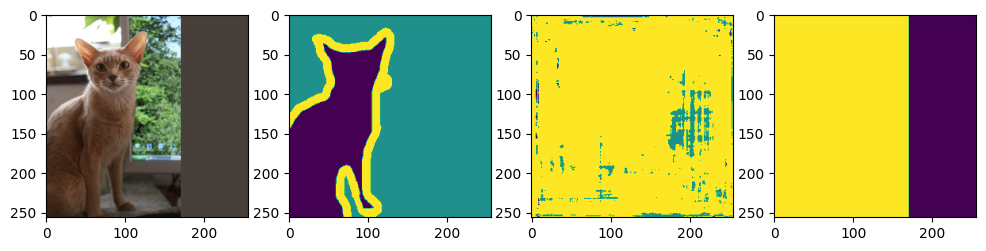

In [40]:
inference(img[0], label[0], mask[0], finetune_model, device)

# Fine-Tune on Semantic Segmentation




In [41]:
lr = 3e-4
save_step = 50
training_step = 10*500
warm_up = int(0.2*training_step)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(finetune_model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warm_up ,num_training_steps=training_step)

step: 1, loss: 0.62546551
step: 2, loss: 0.63251251
step: 3, loss: 0.64166063
step: 4, loss: 0.62620771
step: 5, loss: 0.62023318
step: 6, loss: 0.62448269
step: 7, loss: 0.64847088
step: 8, loss: 0.62232429
step: 9, loss: 0.61126322
step: 10, loss: 0.63427532
step: 11, loss: 0.65113384
step: 12, loss: 0.60114896
step: 13, loss: 0.59332794
step: 14, loss: 0.61022550
step: 15, loss: 0.64966345
step: 16, loss: 0.62719429
step: 17, loss: 0.59137857
step: 18, loss: 0.65203393
step: 19, loss: 0.64009744
step: 20, loss: 0.62494022
step: 21, loss: 0.65162343
step: 22, loss: 0.61854422
step: 23, loss: 0.63955683
step: 24, loss: 0.62287313
step: 25, loss: 0.64665341
step: 26, loss: 0.62805897
step: 27, loss: 0.61371464
step: 28, loss: 0.64584506
step: 29, loss: 0.60992837
step: 30, loss: 0.64541143
step: 31, loss: 0.65005636
step: 32, loss: 0.63791257
step: 33, loss: 0.63603741
step: 34, loss: 0.63672590
step: 35, loss: 0.66737169
step: 36, loss: 0.63434815
step: 37, loss: 0.64693278
step: 38, 

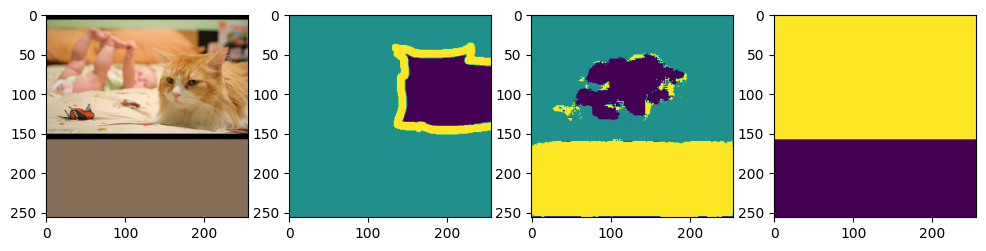

Model checkpoint saved at step 50
----------------------------------------
step: 51, loss: 0.62898386
step: 52, loss: 0.61921638
step: 53, loss: 0.60353559
step: 54, loss: 0.56891876
step: 55, loss: 0.61510921
step: 56, loss: 0.61709201
step: 57, loss: 0.62914556
step: 58, loss: 0.61445397
step: 59, loss: 0.60305583
step: 60, loss: 0.61282372
step: 61, loss: 0.60308206
step: 62, loss: 0.57546508
step: 63, loss: 0.59511375
step: 64, loss: 0.58061439
step: 65, loss: 0.61271876
step: 66, loss: 0.63128614
step: 67, loss: 0.61179310
step: 68, loss: 0.61242980
step: 69, loss: 0.63047665
step: 70, loss: 0.60312688
step: 71, loss: 0.62533939
step: 72, loss: 0.60898262
step: 73, loss: 0.60498035
step: 74, loss: 0.61727059
step: 75, loss: 0.56521815
step: 76, loss: 0.58247173
step: 77, loss: 0.59097958
step: 78, loss: 0.57013959
step: 79, loss: 0.56648558
step: 80, loss: 0.56330699
step: 81, loss: 0.57892138
step: 82, loss: 0.56049901
step: 83, loss: 0.57023120
step: 84, loss: 0.54835343
step: 8

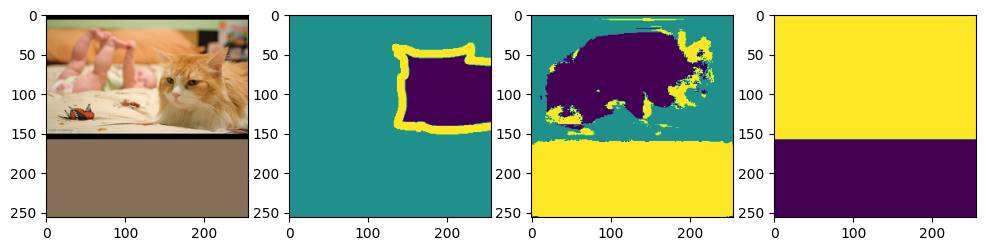

Model checkpoint saved at step 100
----------------------------------------
step: 101, loss: 0.56608599
step: 102, loss: 0.58746266
step: 103, loss: 0.59357095
step: 104, loss: 0.58507711
step: 105, loss: 0.63617939
step: 106, loss: 0.62791878
step: 107, loss: 0.60469902
step: 108, loss: 0.59423530
step: 109, loss: 0.57397383
step: 110, loss: 0.56639647
step: 111, loss: 0.60192800
step: 112, loss: 0.59778732
step: 113, loss: 0.56627625
step: 114, loss: 0.56616479
step: 115, loss: 0.56320894
step: 116, loss: 0.57298207
step: 117, loss: 0.56533921
step: 118, loss: 0.55495572
step: 119, loss: 0.53211015
step: 120, loss: 0.56431115
step: 121, loss: 0.54568630
step: 122, loss: 0.54778206
step: 123, loss: 0.55376780
step: 124, loss: 0.56840140
step: 125, loss: 0.58476180
step: 126, loss: 0.58490843
step: 127, loss: 0.58165067
step: 128, loss: 0.55631375
step: 129, loss: 0.52283186
step: 130, loss: 0.55695170
step: 131, loss: 0.56949311
step: 132, loss: 0.55342835
step: 133, loss: 0.55004007


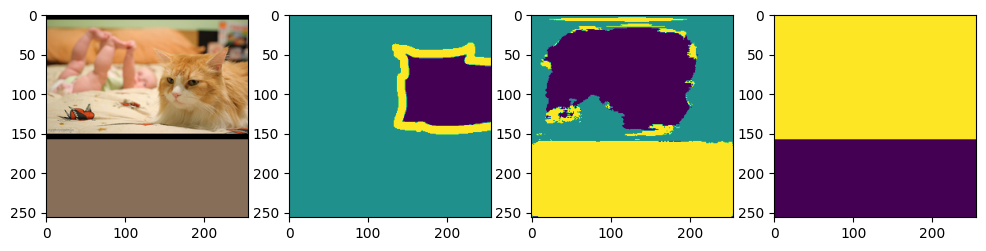

Model checkpoint saved at step 150
----------------------------------------
step: 151, loss: 0.56614274
step: 152, loss: 0.55514973
step: 153, loss: 0.54984742
step: 154, loss: 0.55180389
step: 155, loss: 0.54062319
step: 156, loss: 0.55068958
step: 157, loss: 0.57726228
step: 158, loss: 0.56424505
step: 159, loss: 0.54817057
step: 160, loss: 0.58026963
step: 161, loss: 0.56552720


KeyboardInterrupt: ignored

In [47]:
model_name = 'base'

loss_list = []
valid_loss_list = []
step = 0

stop = 0
best_loss = float('inf')

while True:

    for X in train_loader:

        img, label, mask = X[0].to(device), X[1].long().to(device), X[2].to(device)
        concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 

        finetune_model.train()
        output = finetune_model(concated)
        loss = criterion(output*(mask.unsqueeze(1)), (label*mask).long())
        loss_list.append(loss.item())
        print(f"step: {step+1}, loss: {loss.item():.8f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        step += 1

        if step % save_step == 0:
            
            print(40*'-')
            finetune_model.eval()
            total_loss = 0.0
            for X in valid_loader:
                img, label, mask = X[0].to(device), X[1].long().to(device), X[2].to(device)
                concated = torch.concat([img, mask.unsqueeze(1)], dim=1) 
                with torch.no_grad():
                    output = finetune_model(concated)
                loss = criterion(output*(mask.unsqueeze(1)), (label*mask).long())
                total_loss += loss.item() * img.shape[0]
            valid_loss = total_loss/len(valid_loader.dataset)
            valid_loss_list.append(valid_loss)
            print(f'Averaged Train Loss: {np.mean(loss_list):.8f}, Test Loss: {valid_loss:.8f}')
            
            inference(img[0], label[0], mask[0], finetune_model, device)
            
            model_state_dict = {'encoder': finetune_model.encoder.state_dict(),
                                'decoder': finetune_model.decoder.state_dict(),
                                'mask': finetune_model.segmentation_head.state_dict(),
                                'optimizer': optimizer.state_dict(),
                                'scheduler': scheduler.state_dict()}
            torch.save(model_state_dict, f'/content/drive/MyDrive/Colab Notebooks/ADL Group Project/{model_name}.pth')
            print(f'Model checkpoint saved at step {step}')
            print(40*'-')

            if valid_loss >= best_loss:
                stop += 1
            else:
                best_loss = valid_loss 
                stop = 0

            if stop >= 5:
                print('Early stopped at step: ', step)


        if step == training_step:
            break
            
    if step == training_step:
        break

np.save(f'/content/drive/MyDrive/Colab Notebooks/ADL Group Project/{model_name}_loss.npy', np.array(loss_list))
np.save(f'/content/drive/MyDrive/Colab Notebooks/ADL Group Project/{model_name}_valid_loss.npy', np.array(valid_loss_list))

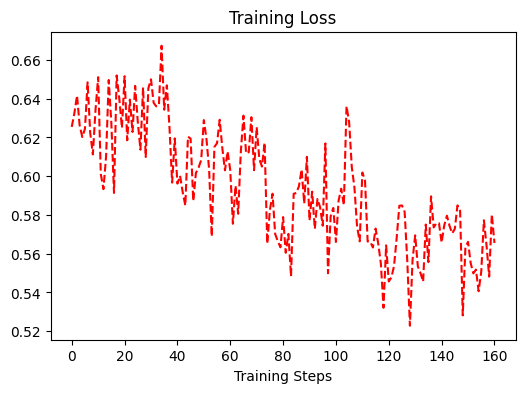

In [48]:
plt.figure(figsize=(6,4))
plt.plot(loss_list, 'r--')
plt.title('Training Loss')
plt.xlabel('Training Steps')
plt.show()

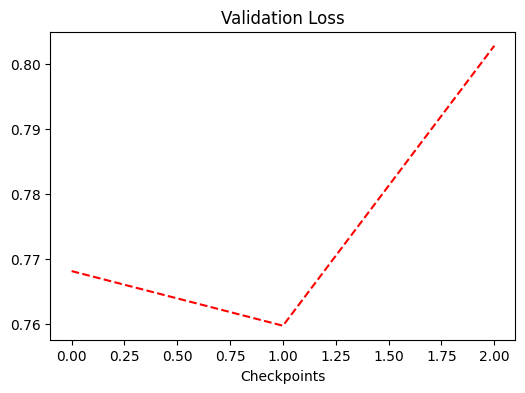

In [49]:
plt.figure(figsize=(6,4))
plt.plot(valid_loss_list, 'r--')
plt.title('Validation Loss')
plt.xlabel('Checkpoints')
plt.show()

In [50]:
min(valid_loss_list)

0.7597452675974047

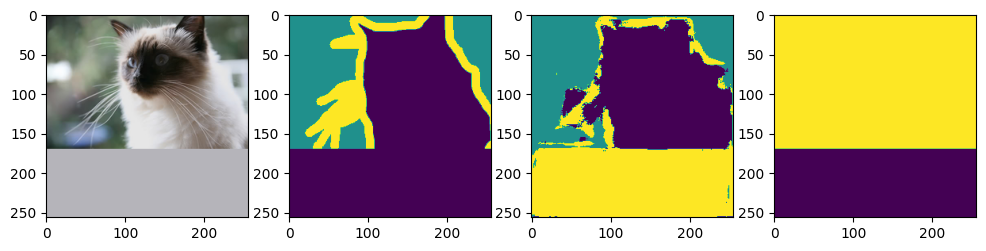

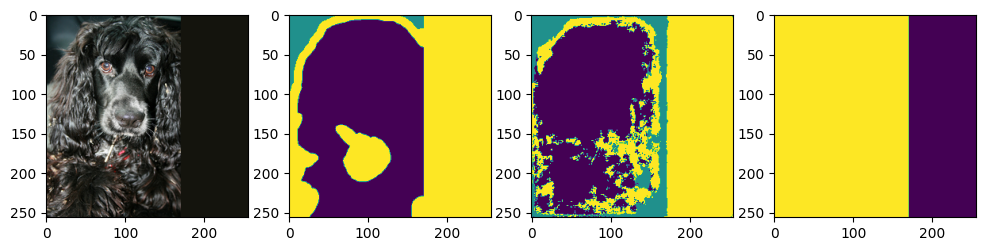

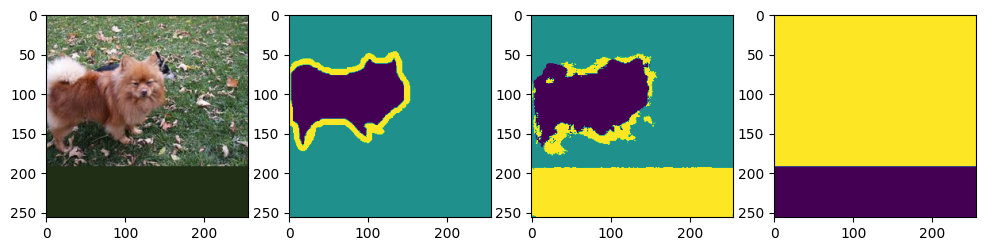

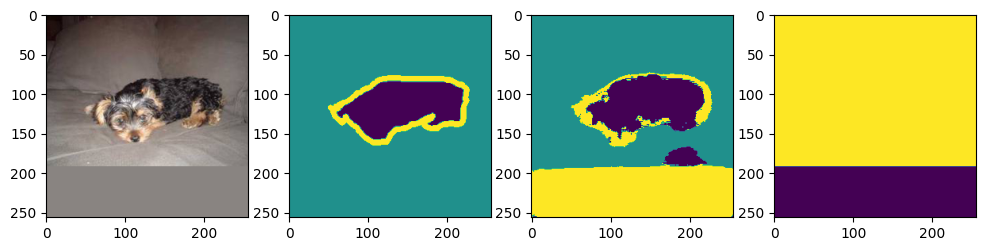

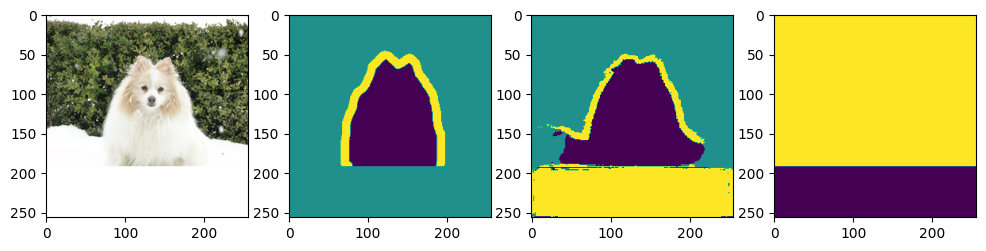

In [51]:
img, label, mask = next(iter(train_loader))

for i in range(5):
    i += 10
    inference(img[i], label[i], mask[i], finetune_model, device)

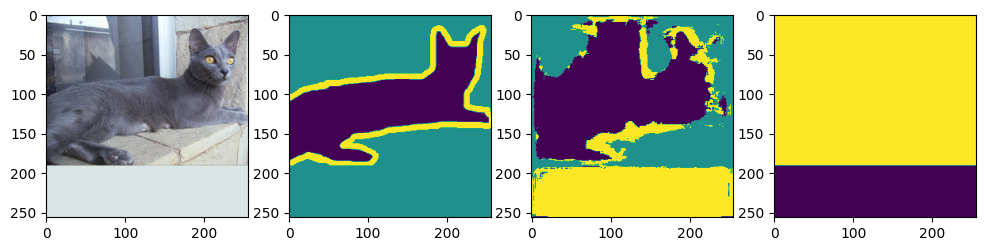

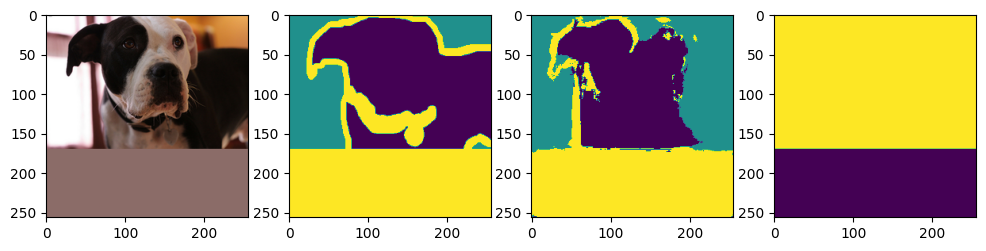

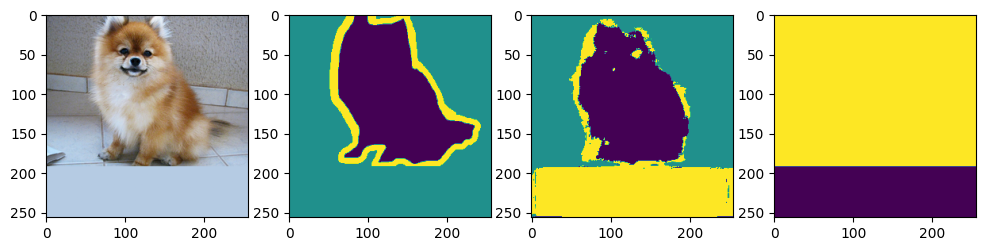

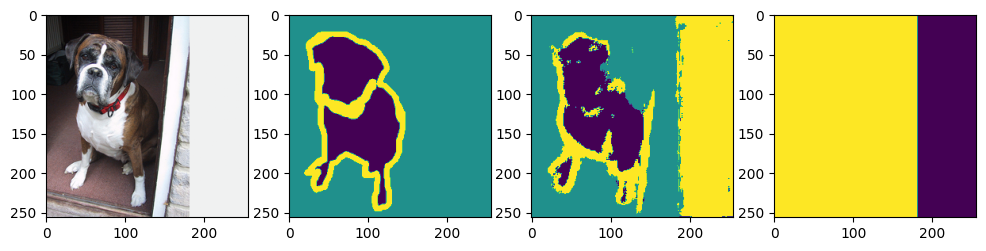

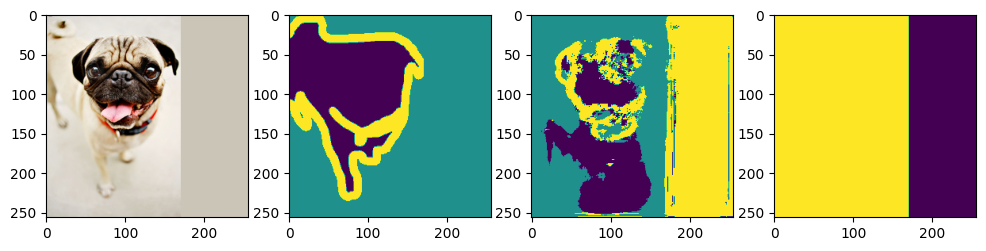

In [52]:
img, label, mask = next(iter(test_loader))

for i in range(5):
    inference(img[i], label[i], mask[i], finetune_model, device)